### Read "criteria" and "trial" files and  output timeseries records (code by Jamie DeAntonis)

In [1]:
import numpy as np
import pandas as pd
import pyzipcode as pzip

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

from matplotlib import pyplot as plt

In [2]:
crit = pd.read_csv('all_criteria_for_azure.csv')
info = pd.read_csv('aact_trial_info.csv')
info = info[info.study_type.isin(['Interventional', 'Expanded Access'])]

In [78]:
# this is the main dataset that we will use

Y = pd.get_dummies(crit[['nct_id', 'concept_name', 'domain', 'is_exclusion']] \
                        .join(info[['nct_id', 'start_date']].set_index('nct_id'), on='nct_id', how='right') \
                        .dropna(axis=0, how='all', subset=['start_date']),
                   columns=['concept_name']) \
      .drop(labels=['domain'], axis=1) \
      .dropna(axis=0, how='all', subset=['is_exclusion']) \
      .drop_duplicates()

Y = Y.assign(start_date=pd.to_datetime(Y.start_date))

Y = Y[Y.start_date.dt.year == 2020]
Y = Y[Y.start_date < pd.to_datetime('2020-06-02')].set_index(keys=['nct_id', 'start_date', 'is_exclusion'])
Y = Y.mask(Y > 1, 1)  # patch work for duplicates
Y = Y.reset_index()

In [42]:
### THIS WILL GENERATE THE CUMULATIVE DF

temp = Y \
        .drop_duplicates() \
        .groupby(by=['nct_id', 'start_date'], axis=0) \
        .aggregate(func=np.sum) \
        .reset_index() \
        .sort_values(by='start_date') \
        .reset_index(drop=True)

temp0 = temp \
        .assign(count = lambda row: row.index + 1) \
        .set_index(keys=['nct_id', 'is_exclusion', 'start_date', 'count'])
temp0 = temp0.mask(temp0 > 0, 1)  # patch work for duplicates

# ensure that maximum appearances of any criterion in any nct_id is exactly 1
# (i.e. must appear somewhere but never same trial twice
#assert np.sum(Y.set_index(keys=['nct_id', 'is_exclusion', 'start_date']).sum(axis=1) \
#              - np.ones((Y.shape[0],))) == 0

temp1 = temp0 \
        .cumsum()  # number of times we've seen this to date

temp2 = temp1 \
        .divide(temp1.index.get_level_values('count'), axis=0) \
        .reset_index() \
        .drop(labels=['nct_id', 'is_exclusion', 'count'], axis=1) \
        .groupby('start_date') \
        .aggregate(np.min, axis=0) \
        .reset_index()

temp3 = temp2 \
        .set_index(pd.to_datetime(temp2.start_date)) \
        .drop('start_date', axis=1) \
        .resample('D') \
        .bfill() \
        .interpolate()

df = temp3 \
        .sort_values(by=temp3.last_valid_index(), axis=1, ascending=False) \
        .iloc[:, :50]

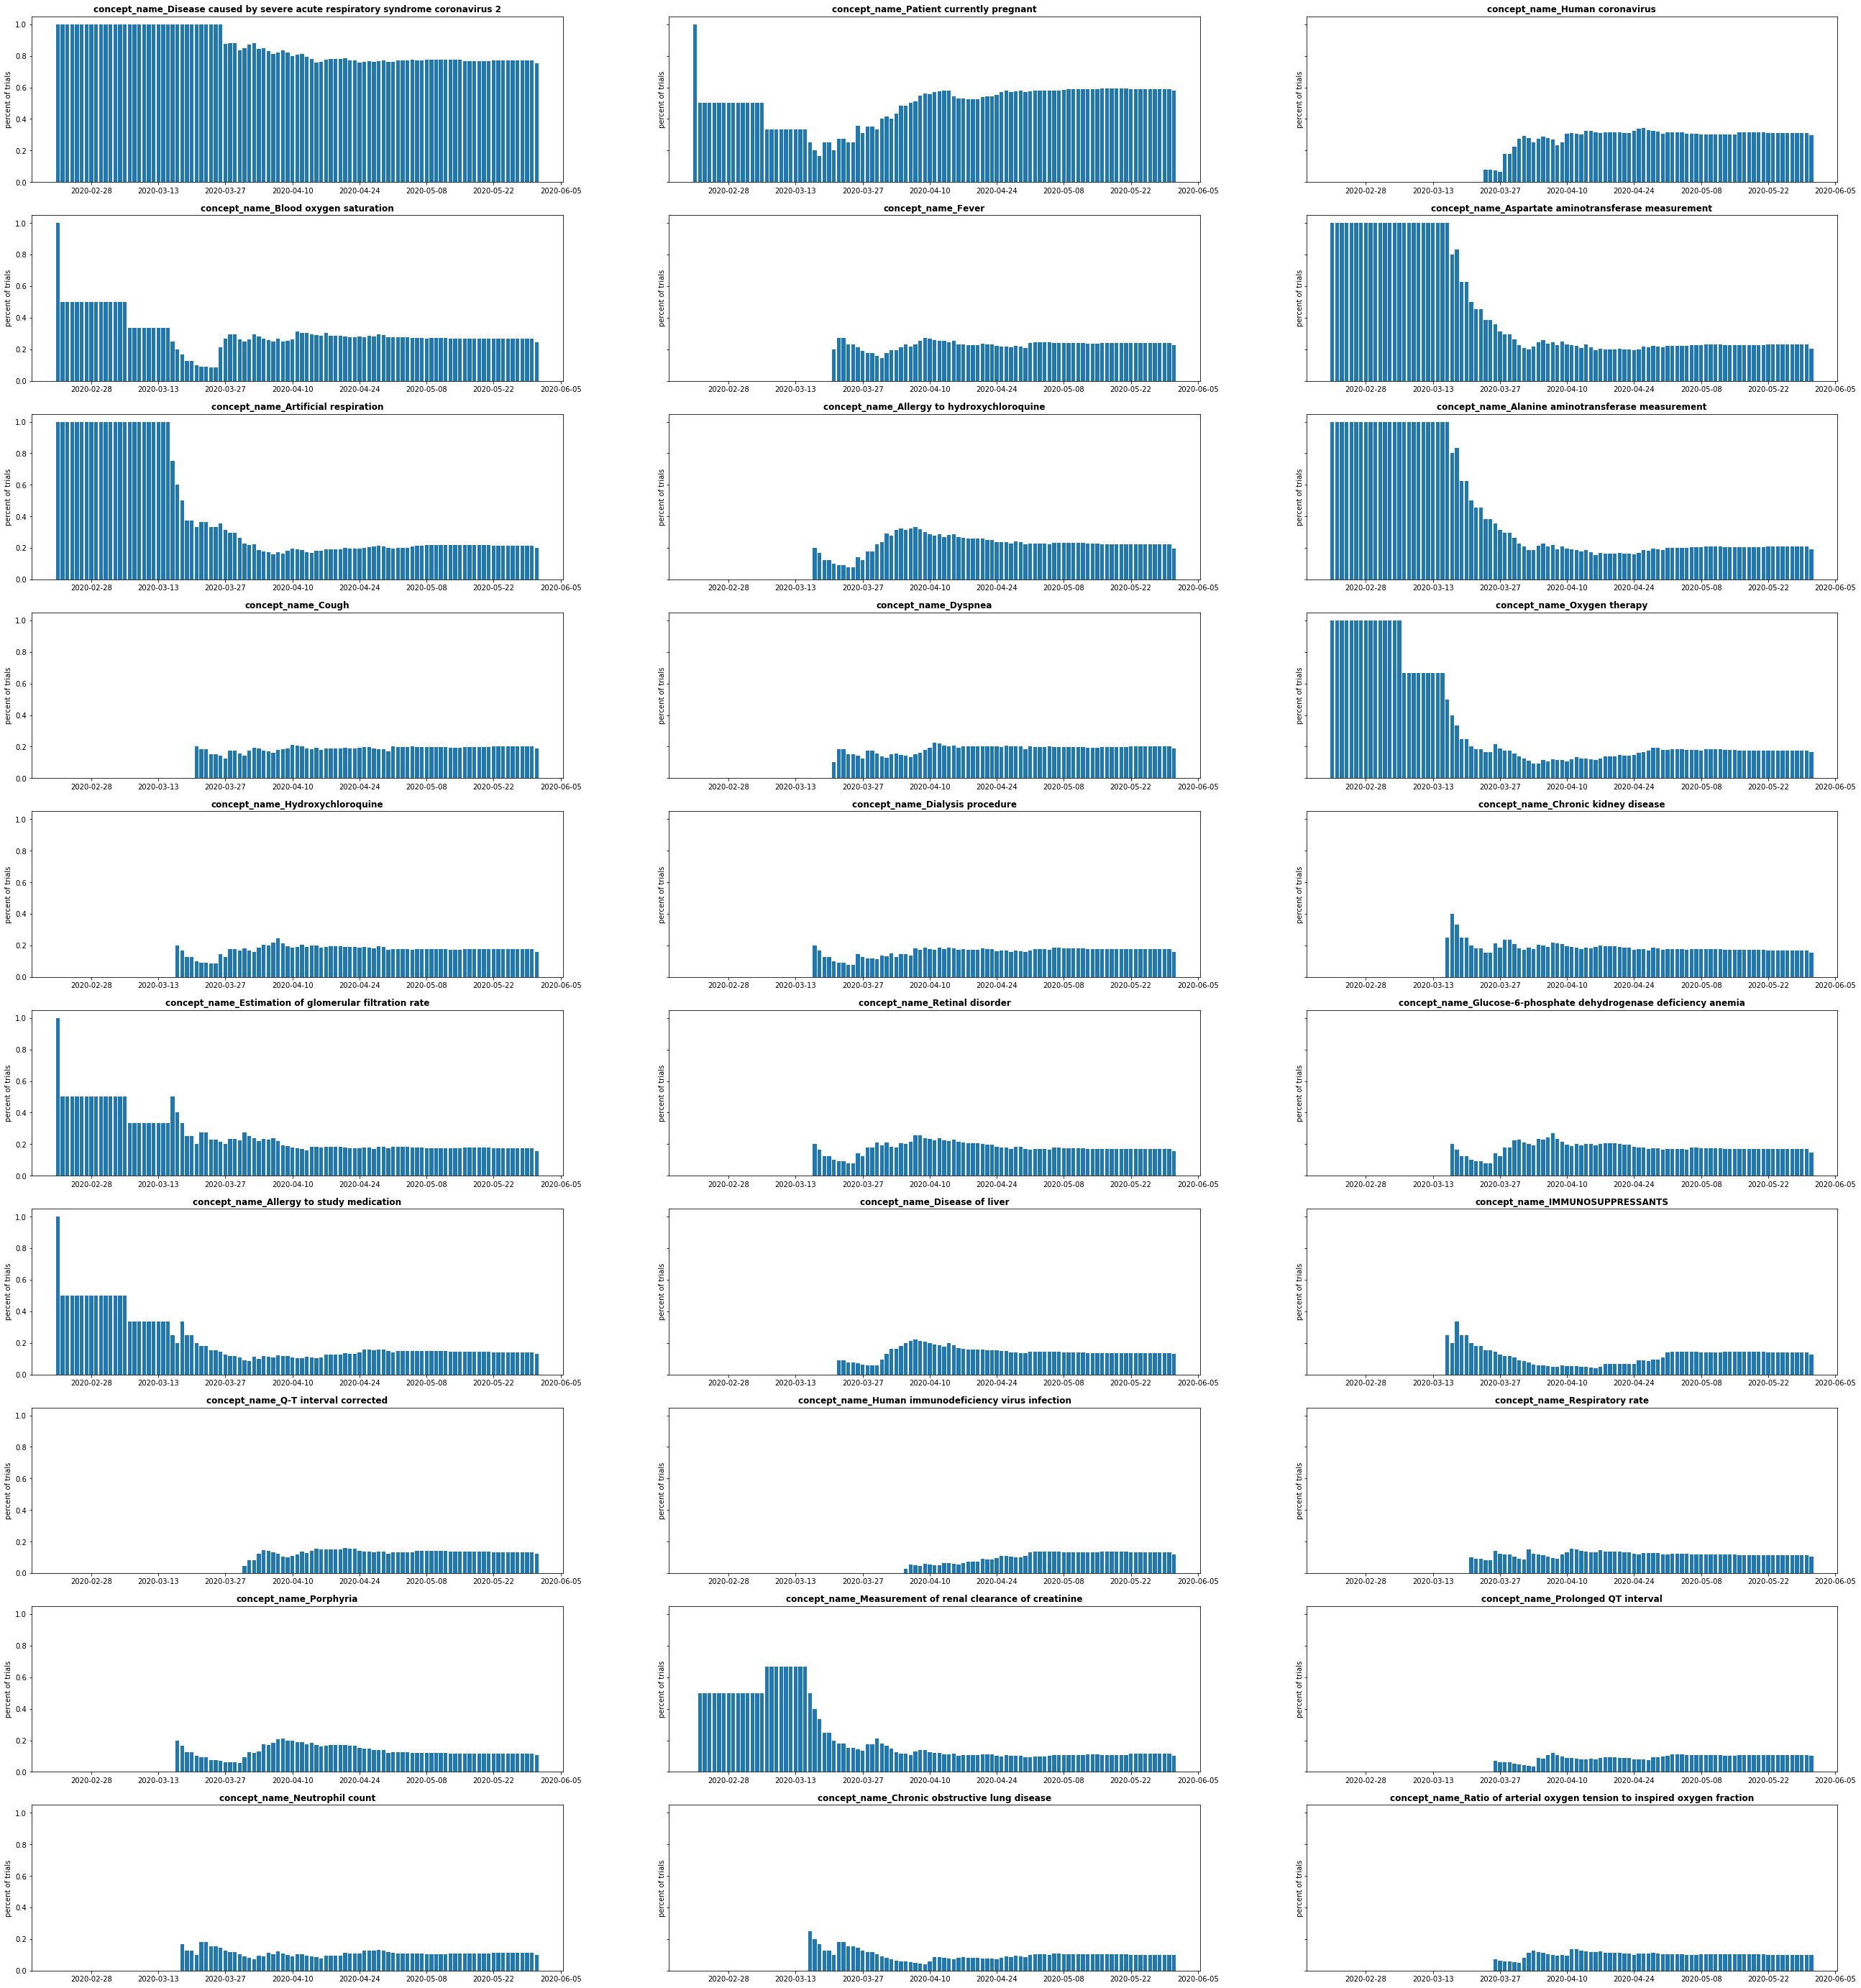

In [7]:
make_plot_grid(df)

### Hierarchical Clustering Dendrogram

In [73]:
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
import matplotlib.pyplot as plt

In [77]:
df_daily = df.T
Z = linkage(df_daily, 'ward')

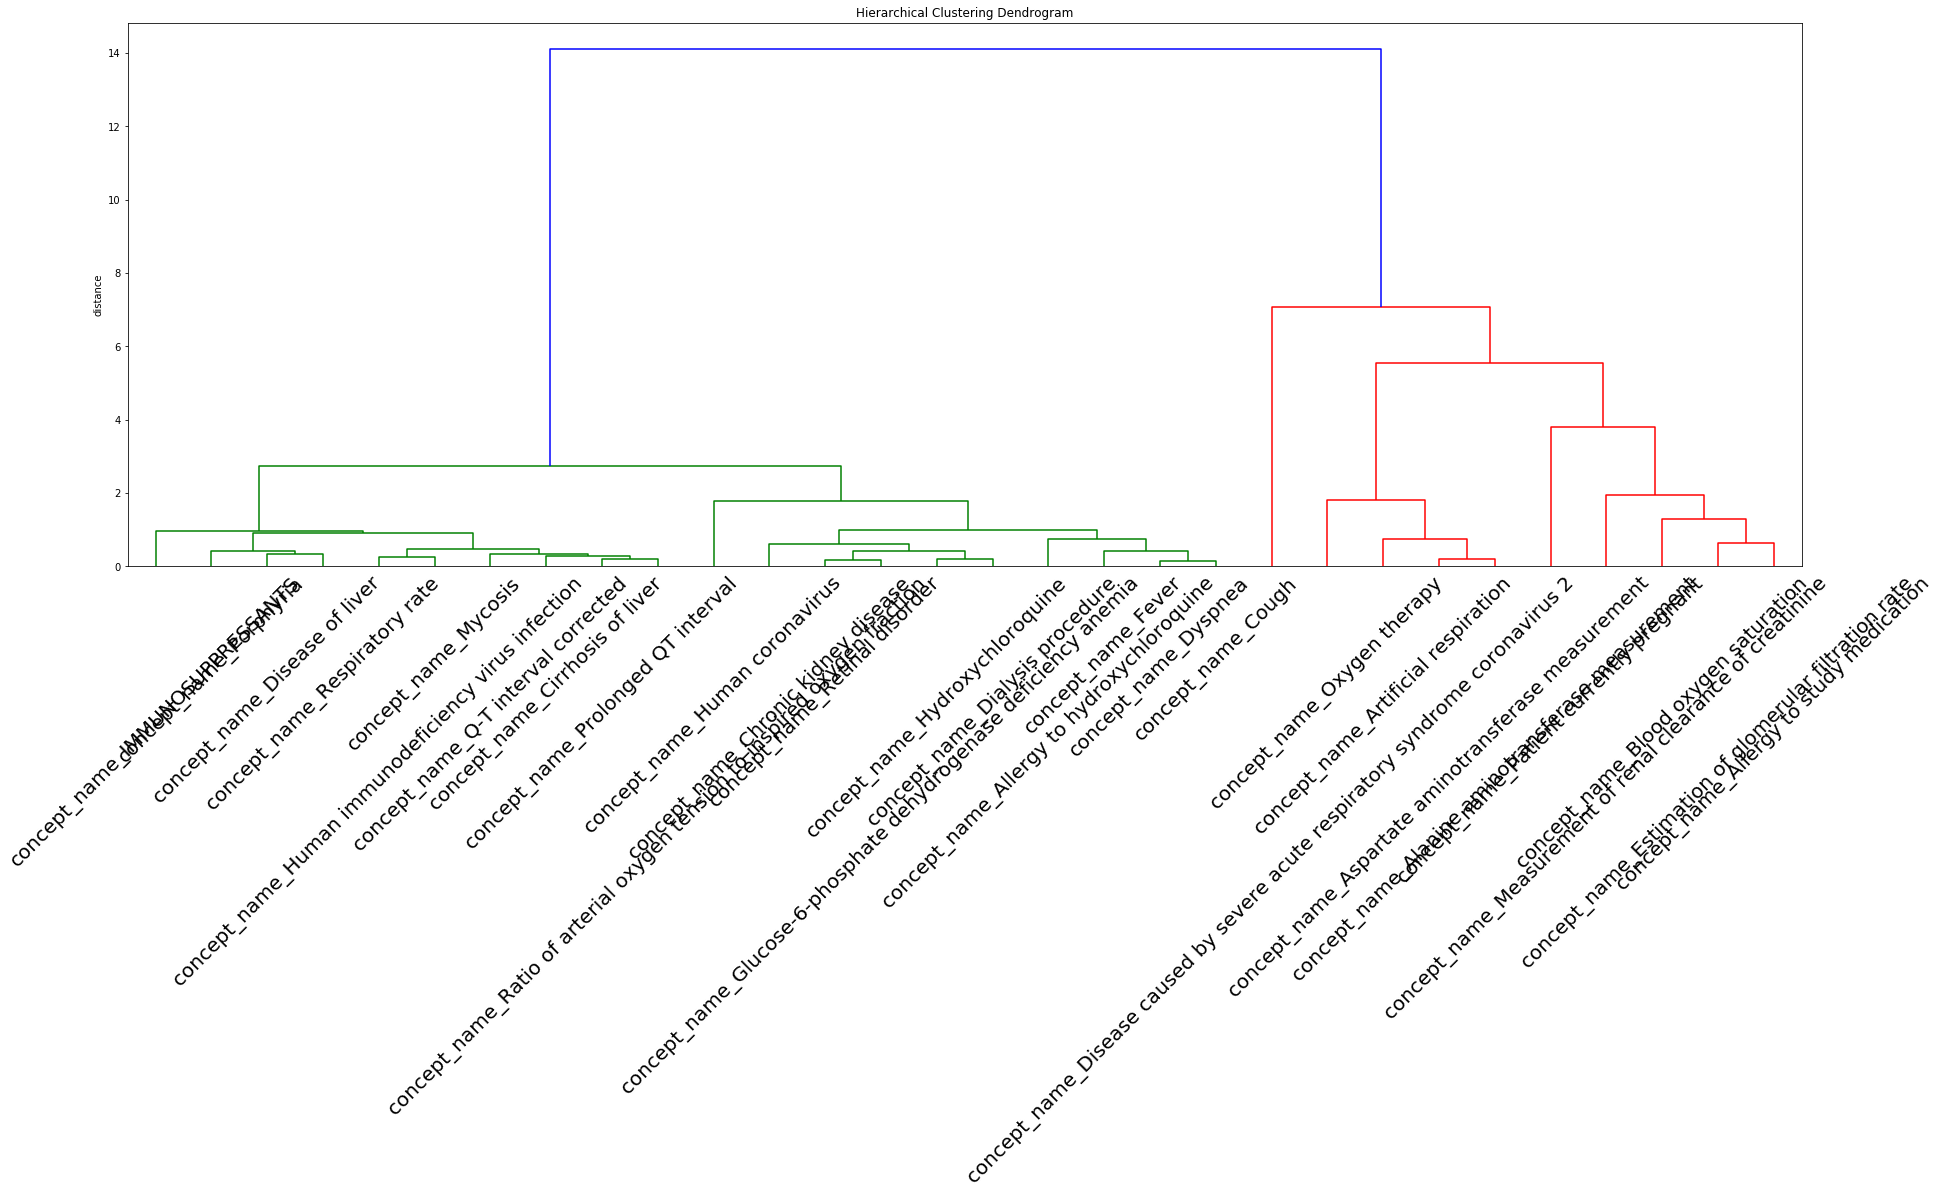

In [78]:
plt.figure(figsize=(30,10))
plt.title('Hierarchical Clustering Dendrogram')
#plt.xlabel('sample index')
plt.ylabel('distance')

dendrogram(
    Z,
    #truncate_mode='lastp',
    #p=12,
    #show_leaf_counts=False,
    #leaf_rotation=90.,
    leaf_font_size=20,
    #show_contracted=True,
    labels = df.T.index
)
plt.show()

In [187]:
k=15
df_daily['group'] = fcluster(Z, k, criterion='maxclust')

In [188]:
groups = dict()
for i in range(k):
    groups[f'group_{i+1}'] = df_daily[df_daily['group']==i+1].index

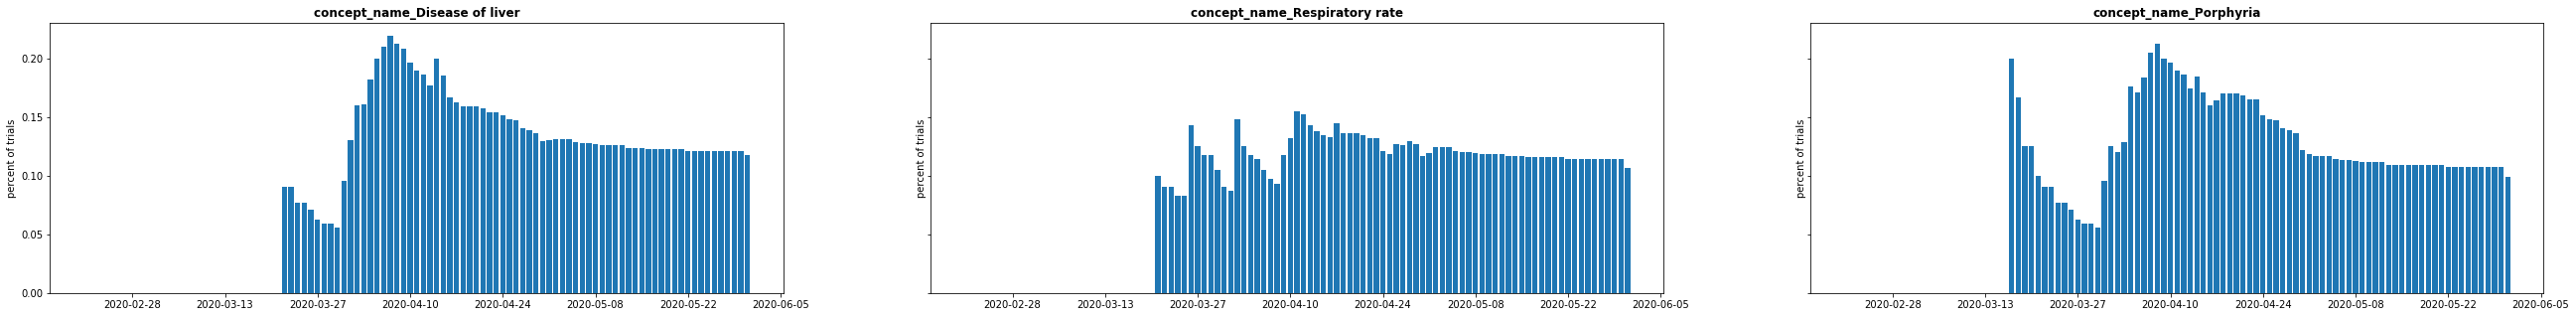

In [193]:
make_plot_grid(df[groups['group_1']])
#df_daily.iloc[2:3, :-1].T

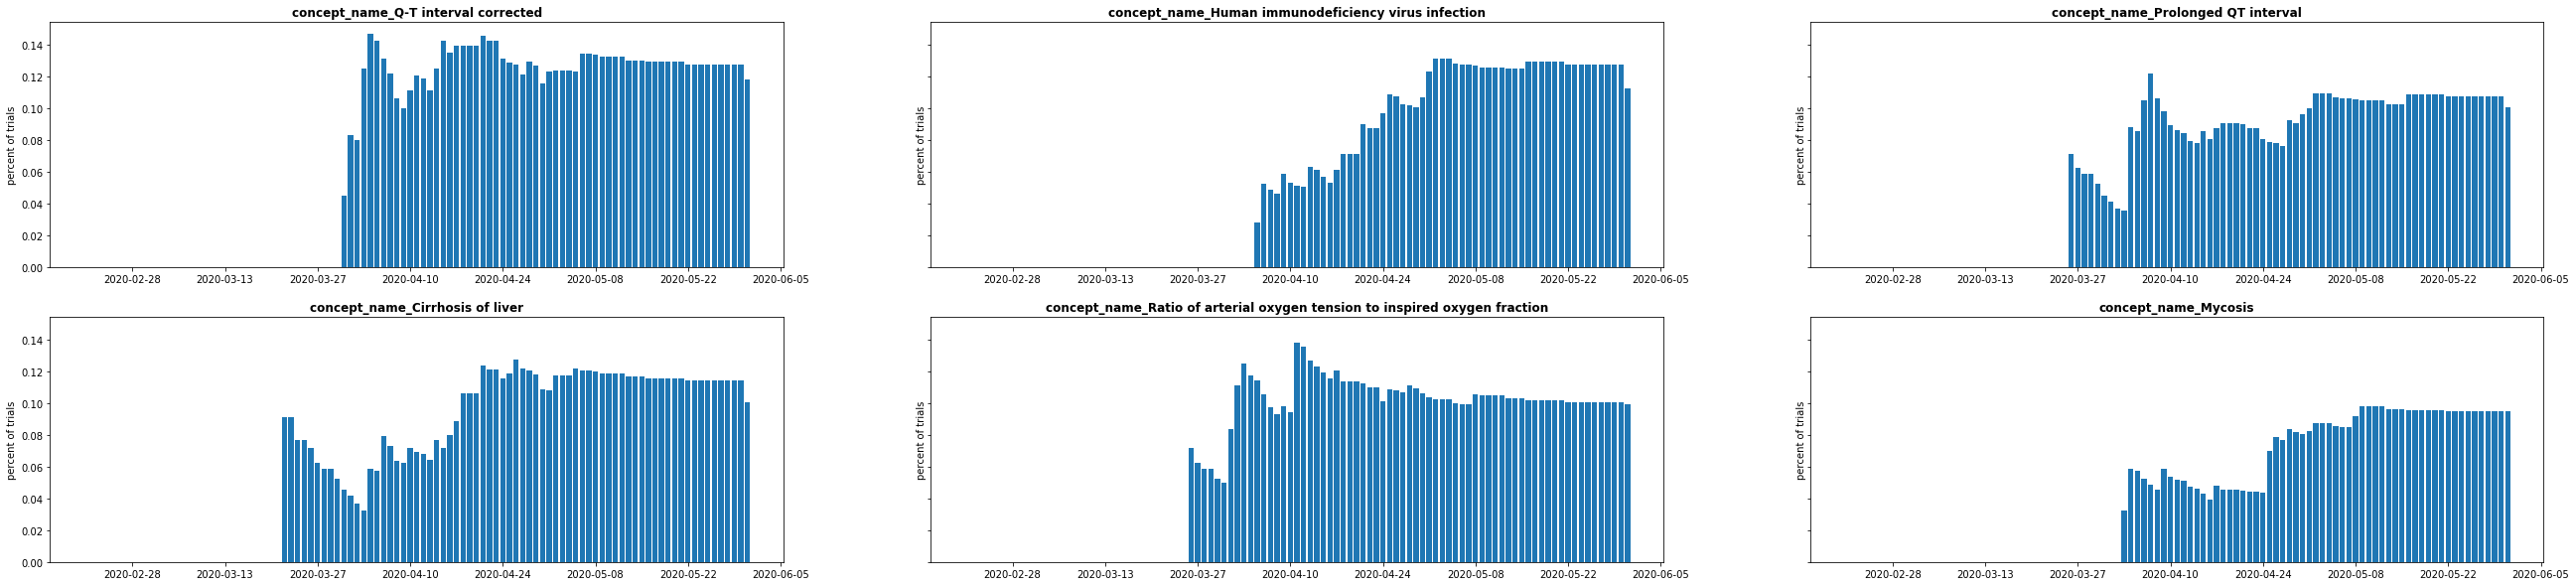

In [194]:
make_plot_grid(df[groups['group_2']])

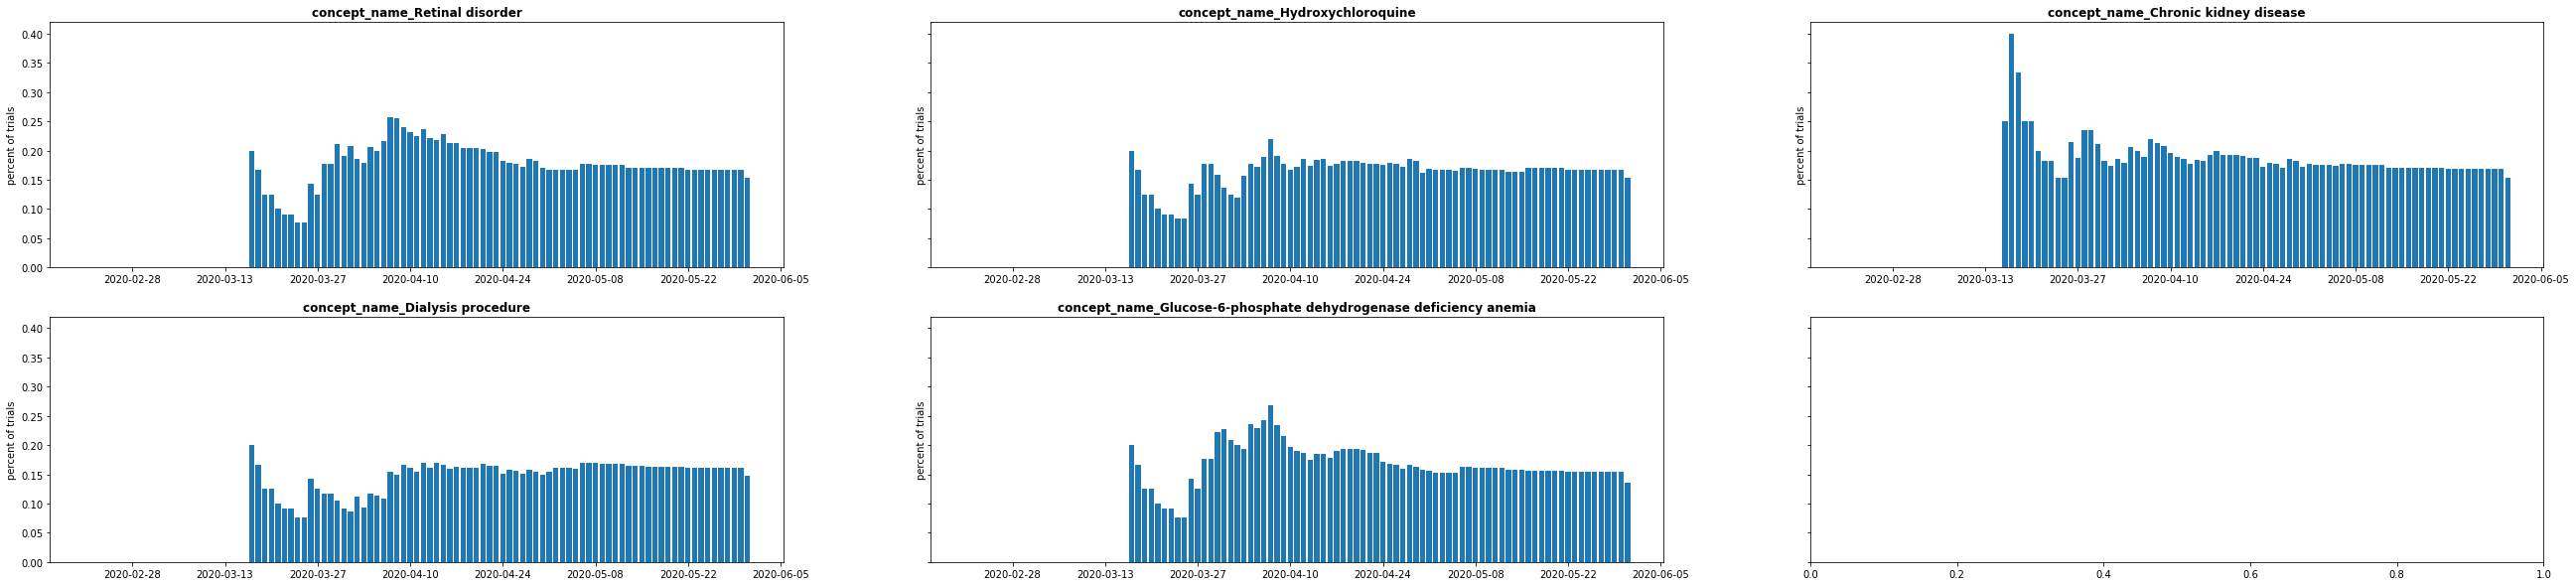

In [196]:
make_plot_grid(df[groups['group_4']])

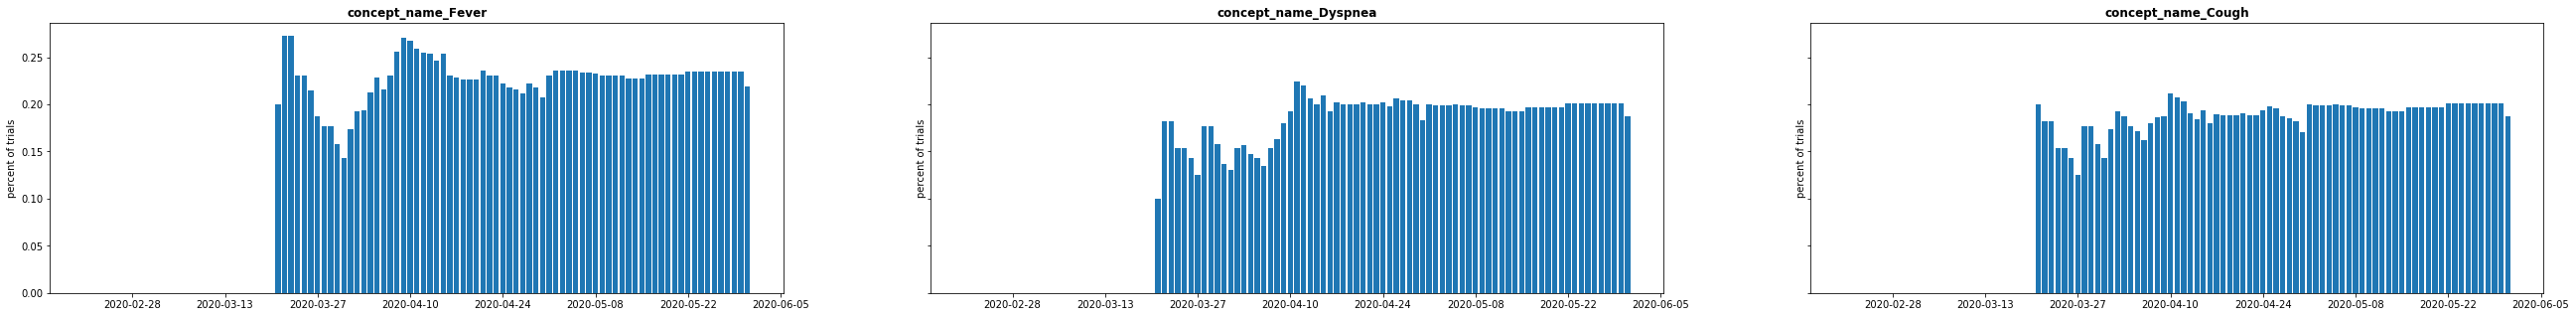

In [198]:
make_plot_grid(df[groups['group_5']])

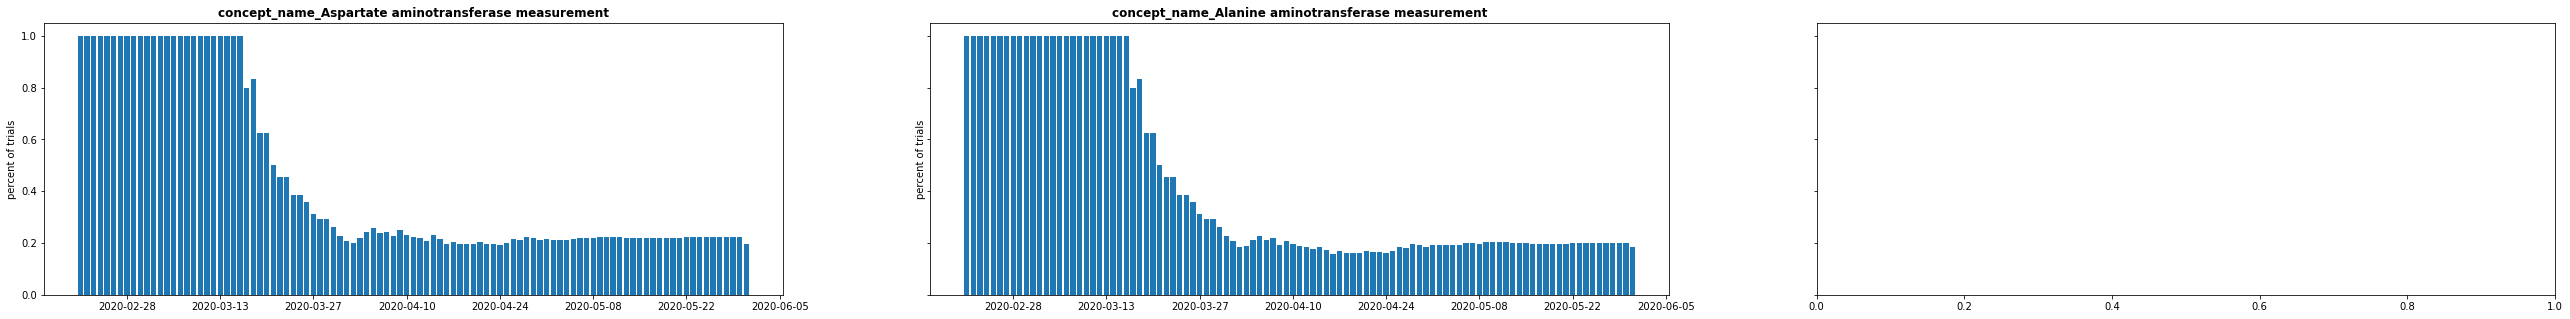

In [199]:
make_plot_grid(df[groups['group_8']])

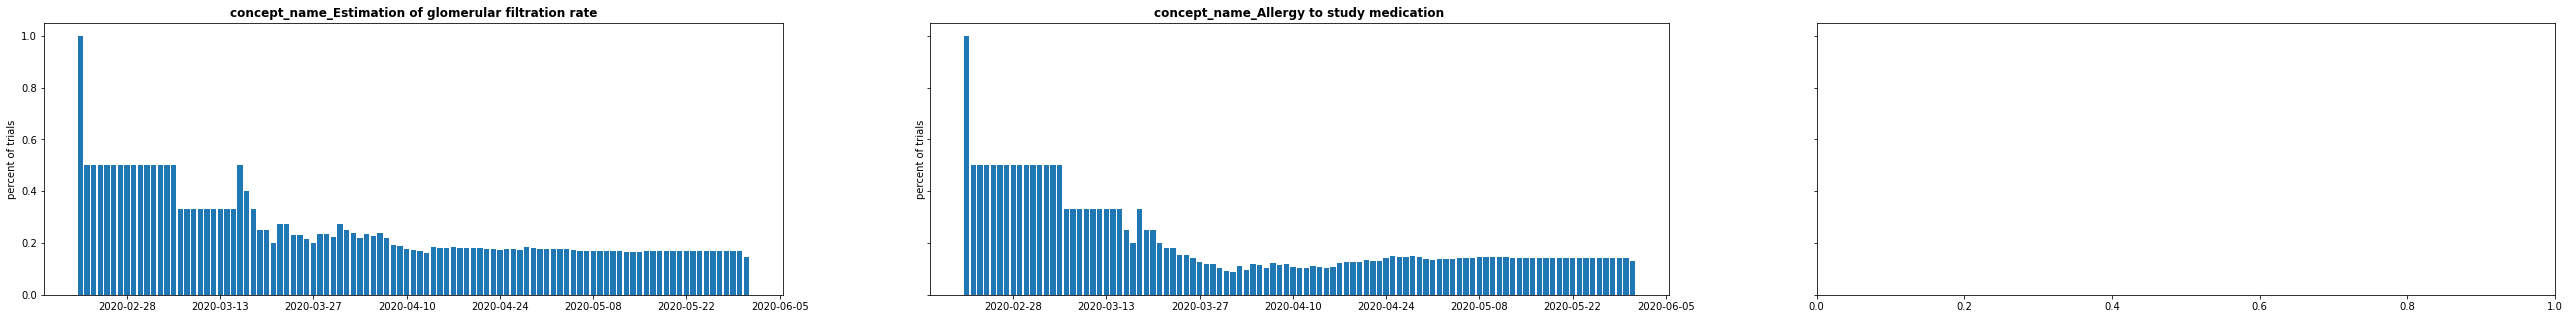

In [200]:
make_plot_grid(df[groups['group_11']])

In [201]:
groups

{'group_1': Index(['concept_name_Disease of liver', 'concept_name_Respiratory rate',
        'concept_name_Porphyria'],
       dtype='object'),
 'group_2': Index(['concept_name_Q-T interval corrected',
        'concept_name_Human immunodeficiency virus infection',
        'concept_name_Prolonged QT interval', 'concept_name_Cirrhosis of liver',
        'concept_name_Ratio of arterial oxygen tension to inspired oxygen fraction',
        'concept_name_Mycosis'],
       dtype='object'),
 'group_3': Index(['concept_name_IMMUNOSUPPRESSANTS'], dtype='object'),
 'group_4': Index(['concept_name_Retinal disorder', 'concept_name_Hydroxychloroquine',
        'concept_name_Chronic kidney disease',
        'concept_name_Dialysis procedure',
        'concept_name_Glucose-6-phosphate dehydrogenase deficiency anemia'],
       dtype='object'),
 'group_5': Index(['concept_name_Fever', 'concept_name_Dyspnea', 'concept_name_Cough'], dtype='object'),
 'group_6': Index(['concept_name_Allergy to hydroxychloro